In [ ]:
import numpy as mp
import time
import os
import xml.etree.ElementTree as ET
import os
import pickle
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        obj_struct['truncated'] = int(obj.find('truncated').text)
        obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text),
                              int(bbox.find('ymin').text),
                              int(bbox.find('xmax').text),
                              int(bbox.find('ymax').text)]
        objects.append(obj_struct)

    return objects

def voc_eval(det_result,
             annopath,
             imagesetfile,
             classname,
             cachedir,
             ovthresh=0.5,
             use_07_metric=False):
    """rec, prec, ap = voc_eval(detpath,
                                annopath,
                                imagesetfile,
                                classname,
                                [ovthresh],
                                [use_07_metric])

    Top level function that does the PASCAL VOC evaluation.

    detpath: Path to detections
        detpath.format(classname) should produce the detection results file.
    annopath: Path to annotations
        annopath.format(imagename) should be the xml annotations file.
    imagesetfile: Text file containing the list of images, one image per line.
    classname: Category name (duh)
    cachedir: Directory for caching the annotations
    [ovthresh]: Overlap threshold (default = 0.5)
    [use_07_metric]: Whether to use VOC07's 11 point AP computation
        (default False)
    """
    # assumes detections are in detpath.format(classname)
    # assumes annotations are in annopath.format(imagename)
    # assumes imagesetfile is a text file with each line an image name
    # cachedir caches the annotations in a pickle file

    # first load gt
    if not os.path.isdir(cachedir):
        os.mkdir(cachedir)
    cachefile = os.path.join(cachedir, 'annots.pkl')
    # read list of images
    with open(imagesetfile, 'r') as f:
        lines = f.readlines()
        #print(lines)
    imagenames = [x.strip() for x in lines]

    if not os.path.isfile(cachefile):
        # load annots
        recs = {}
        for i, imagename in enumerate(imagenames):
            recs[imagename] = parse_rec(annopath.format(imagename))
            if i % 100 == 0:
                print('Reading annotation for {:d}/{:d}'.format(
                    i + 1, len(imagenames)))
        # save
        print('Saving cached annotations to {:s}'.format(cachefile))
        with open(cachefile, 'wb') as f:
            pickle.dump(recs, f)
    else:
        # load
        with open(cachefile, 'rb') as f:
            recs = pickle.load(f)

    # extract gt objects for this class
    class_recs = {}
    npos = 0
    for imagename in imagenames:
        R = [obj for obj in recs[imagename] if obj['name'] == classname]
        bbox = np.array([x['bbox'] for x in R])
        difficult = np.array([x['difficult'] for x in R]).astype(np.bool_)
        det = [False] * len(R)
        npos = npos + sum(~difficult)
        class_recs[imagename] = {'bbox': bbox,
                                 'difficult': difficult,
                                 'det': det}

    # read dets
    #with open(detfile, 'r') as f:
    #    lines = f.readlines()

    lines = det_result


    # using "__" instead of " " because the data path under Google drive is all "/content/drive/My Drive/...
    # Therefore, the following .split(' ') function would result in error
    #splitlines = [x.strip().split('__') for x in lines]
    splitlines = [x.strip().split(' ') for x in lines]
    image_ids = [x[0] for x in splitlines]
    confidence = np.array([float(x[1]) for x in splitlines])
    BB = np.array([[float(z) for z in x[2:]] for x in splitlines])

    # sort by confidence
    sorted_ind = np.argsort(-confidence)
    sorted_scores = np.sort(-confidence)
    BB = BB[sorted_ind, :]
    image_ids = [image_ids[x] for x in sorted_ind]

    # go down dets and mark TPs and FPs
    nd = len(image_ids)
    tp = np.zeros(nd)
    fp = np.zeros(nd)
    for d in range(nd):
        R = class_recs[image_ids[d]]
        bb = BB[d, :].astype(float)
        ovmax = -np.inf
        BBGT = R['bbox'].astype(float)

        if BBGT.size > 0:
            # compute overlaps
            # intersection
            ixmin = np.maximum(BBGT[:, 0], bb[0])
            iymin = np.maximum(BBGT[:, 1], bb[1])
            ixmax = np.minimum(BBGT[:, 2], bb[2])
            iymax = np.minimum(BBGT[:, 3], bb[3])
            iw = np.maximum(ixmax - ixmin + 1., 0.)
            ih = np.maximum(iymax - iymin + 1., 0.)
            inters = iw * ih

            # union
            uni = ((bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) +
                   (BBGT[:, 2] - BBGT[:, 0] + 1.) *
                   (BBGT[:, 3] - BBGT[:, 1] + 1.) - inters)

            overlaps = inters / uni
            ovmax = np.max(overlaps)
            jmax = np.argmax(overlaps)

        if ovmax > ovthresh:
            if not R['difficult'][jmax]:
                if not R['det'][jmax]:
                    tp[d] = 1.
                    R['det'][jmax] = 1
                else:
                    fp[d] = 1.
        else:
            fp[d] = 1.


    # compute precision recall
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos)
    # avoid divide by zero in case the first detection matches a difficult
    # ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)

    return rec, prec, ap


def _do_python_eval_quite(mAP_folder, det_result):
  # do remind only PAScal VOC 07 test needs to use use_07_metric ==  True
  # simply replace 2007 with year bigger than 2010 will work
    _year = '2010'

    _classes = ('dog',)

    annopath = mAP_folder + '{:s}.xml'

    imagesetfile = mAP_folder + 'test.txt'

    cachedir = mAP_folder
    aps = []

    result = dict()
    # The PASCAL VOC metric changed in 2010
    use_07_metric = True if int(_year) < 2010 else False

    print("Begin to perform mAP estimation")
    for i, cls in enumerate(_classes):
        #if cls == '__background__':
        #    continue
        #print(cls)
        rec, prec, ap = voc_eval(
            det_result, annopath, imagesetfile, cls, cachedir, ovthresh=0.5,
            use_07_metric=use_07_metric)
        aps += [ap]
        # print('AP for {} = {:.4f}'.format(cls, ap))
        result[cls] = ap
        # the following file (rec, prec, & ap of each class) is only for back-up.
        #with open(os.path.join(output_dir, cls + '_pr.pkl'), 'wb') as f:
        #    pickle.dump({'rec': rec, 'prec': prec, 'ap': ap}, f)

    return result




def plot_boxes_cv2(img, boxes, class_names=None, color=None):

    width = img.shape[1]
    height = img.shape[0]
    #print(len(boxes))
    for box in boxes:

        x1 = box.split(' ')[2]
        y1 = box.split(' ')[3]
        x2 = box.split(' ')[4]
        y2 = box.split(' ')[5]

        x1,x2 = int(float(x1)),int(float(x2))
        y1,y2 = int(float(y1)),int(float(y2))

        #cls_id = int(detection_classses[j,0])
        #prob = float(boxes[j,1])
        prob = float(box.split(' ')[1])
        #print(prob)

        #img = cv2.putText(img, 'dog', (x1,y1),  cv2.FONT_HERSHEY_PLAIN, 1.0, (0,0,255), thickness=1)
        #img = cv2.putText(img, str(round(prob,3)), (x1,y1+20),  cv2.FONT_HERSHEY_PLAIN, 1.0, (0,0,255), thickness=1)
        #img = cv2.rectangle(img, (x1,y1), (x2,y2), (0, 0, 255), 2)

        img = cv2.rectangle(img, (x1,y1), (x2,y2), (0, 255, 0), 2)
        img = cv2.rectangle(img, (x1,y1), (x2,y1+15), (255, 255, 255), -1)
        #resized_image = cv2.putText(resized_image, ' %s: %.2f' % (classes[cls_id],prob) , (x1-5,y1+10),  cv2.FONT_HERSHEY_COMPLEX_SMALL , 11, (0,0,0), thickness=1)
        img = cv2.putText(img, '%s:%.2f' % ('dog',prob) , (x1,y1+13),  cv2.FONT_HERSHEY_COMPLEX_SMALL , 1, (0,0,0), thickness=1)

    return img




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


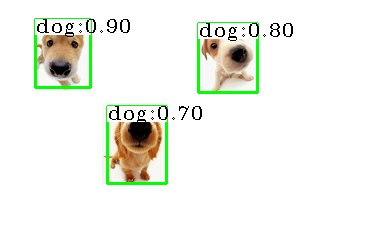

Begin to perform mAP estimation
The AP of class-dog is 1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# step 1:Please download the following folder, unzip it and put the entire folder in your google drive under /content/drive/My Drive/
# https://drive.google.com/file/d/1seusCbByJjW8Hsgl_A3PH6O8zmYzTY9s/view?usp=sharing


mAP_folder = "/content/drive/My Drive/mAP_estimation/"
img_file = "/content/drive/My Drive/mAP_estimation/000001.jpg"

# orignal setting: simulating detection results in the following list; the format is filename, confidence, x1, y1, x2, y2 row-wise
det_result = ['000001 0.9 35.0 19.0 90.0 87.0', '000001 0.8 198.0 23.0 257.0 92.0', '000001 0.7 107.0 106.0 166.0 183.0']
# new setting-1:
#det_result = ['000001 0.9 35.0 19.0 90.0 87.0', '000001 0.8 198.0 23.0 257.0 92.0', '000001 0.7 107.0 106.0 166.0 183.0','000001 0.1 50.0 100 80.0 130.0','000001 0.3 45.0 29.0 100.0 97.0']
# new setting-2:
#det_result = ['000001 0.9 35.0 19.0 90.0 87.0', '000001 0.8 198.0 23.0 257.0 92.0', '000001 0.7 107.0 106.0 166.0 183.0','000001 0.1 50.0 100 80.0 130.0','000001 0.95 45.0 29.0 100.0 97.0']


# read the image
image = cv2.imread(img_file)

# show the detection results
image = plot_boxes_cv2(image, det_result, class_names = 'dog', color=None)
cv2_imshow(image)

# begin AP or mAP estimation
result = _do_python_eval_quite(mAP_folder, det_result)

print('The AP of class-{} is {}'.format('dog', result.get('dog')))

# New Section